In [7]:
from elk_generalization.results.viz import get_result_dfs
from elk_generalization.utils import get_quirky_model_name

models = [
    "mistralai/Mistral-7B-v0.1",
]
model_scales = {
    "pythia-410m": 0.41,
    "pythia-1b": 1,
    "pythia-1.4b": 1.4,
    "pythia-2.8b": 2.8,
    "pythia-6.9b": 6.9,
    "pythia-12b": 12,
    "Llama-2-7b-hf": 7,
    "Mistral-7B-v0.1": 7,
}
method_titles = {
    "lr": "LogR",
    "mean-diff": "Diff-in-means",
    "mean-diff-on-pair": "Diff-in-means on contrast pair",
    "lda": "LDA",
    "lr-on-pair": "LogR on contrast pair",
    "ccs": "CCS",
    "crc": "CRC",
    "vincs": "VINCS",
}

ds_names = [
    "capitals",
    "hemisphere",
    "population",
    "sciq",
    "sentiment",
    "nli",
    "authors",
    "addition",
    "subtraction",
    "multiplication",
    "modularaddition",
    "squaring",
]

ds_abbrevs = {
    "capitals": "cap",
    "hemisphere": "hem",
    "population": "pop",
    "sciq": "sciq",
    "sentiment": "snt",
    "nli": "nli",
    "authors": "aut",
    "addition": "add",
    "subtraction": "sub",
    "multiplication": "mul",
    "modularaddition": "mod",
    "squaring": "sqr",
}
root = "../../experiments/"


# Qualitative differences

In [8]:
plot_ds_names = ds_names.copy()
plot_models = models
fr, to = "AE", "AE"
filter_by = "all"
if "H" in fr or "E" in fr:
    plot_ds_names.remove("population")  # difficulty is label
if filter_by == "disagreements":
    plot_ds_names.remove("authors")  # authors is only False for disagreements
weak_only = False
metric = "auroc"
methods = ["vincs",]
# var, inv, cov, supervised weights
vincs_hparams = (0.0, 1.0, 0.0, 1.0)
use_leace = False
templatization_method = "random"
standardize_templates = False
full_finetuning = False
ensemble = "full"
label_col="alice_label"
rs = dict()
for reporter in methods:
    rs[reporter] = get_result_dfs(plot_models, fr, to, plot_ds_names, label_col=label_col, ensemble=ensemble, filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root, weak_only=weak_only, vincs_hparams=vincs_hparams, use_leace=use_leace, templatization_method=templatization_method, standardize_templates=standardize_templates, full_finetuning=full_finetuning)

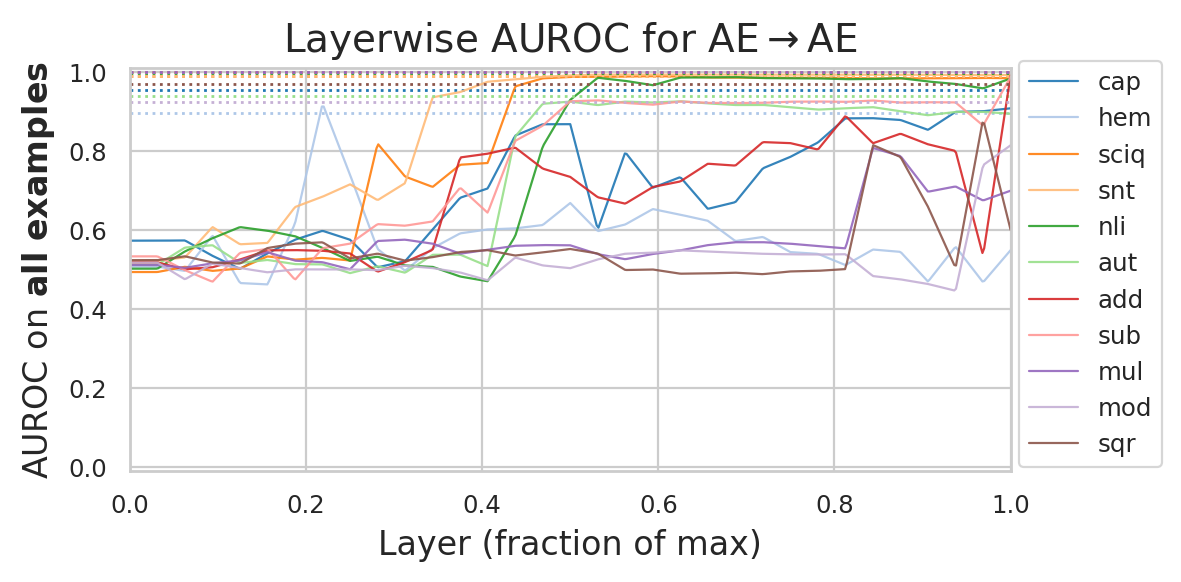

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(6, 3), dpi=200)

for i, method in enumerate(methods):
    avg_reporter_results, per_ds_results_dfs, all_result_dfs, avg_lm_result, per_ds_lm_result_dfs, lm_results = rs[method]
    colors = sns.color_palette("tab20", len(per_ds_results_dfs))
    for j, (key, result_df, lm_result) in enumerate(zip(per_ds_results_dfs.keys(), per_ds_results_dfs.values(), per_ds_lm_result_dfs.values())):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.9, color=colors[j], linewidth=0.8, label=ds_abbrevs[key])
        ax.hlines(lm_result, 0, 1, color=colors[j], linewidth=1, linestyle=":")

    # turn legend on
    if i == 0:
        ax.legend(loc=[1.01, 0.01])

    if i % 3 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on $\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on $\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on $\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=12)
    
    if i == 0:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 3:
        ax.legend(loc="lower left")

plt.title(f"Layerwise {metric.upper()} for {fr}$\\to${to}" + (" weak only" if weak_only else ""), fontsize=14)
plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_qualitative_{fr}_{to}.pdf")
plt.show()

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from viz import earliest_informative_layer
import os
import numpy as np

current_args = dict(
    ds_names=ds_names.copy(),
    models=models,
    fr="AE",
    to="BH",
    filter_by="all",
    weak_only=False,
    metric="auroc",
    reporter="vincs",
    use_leace=True,
    templatization_method="random",
    standardize_templates=True,
    full_finetuning=False,
    ensemble="full",
    label_col="alice_label",
)
if "H" in fr or "E" in fr:
    current_args["ds_names"].remove("population")  # difficulty is label
if filter_by == "disagreements":
    current_args["ds_names"].remove("authors")  # authors is only False for disagreements
# current_args["ds_names"] = [
#     # "capitals",
#     # "hemisphere",
#     # "population",
#     "sciq",
#     "sentiment",
#     "nli",
#     "authors",
#     "addition",
#     "subtraction",
#     # "multiplication",
#     # "modularaddition",
#     # "squaring",
# ]
hparams_list = [
        (var, inv, cov, supervised)
        for var in [0, 1]
        for inv in [0, 0.25, 1, 4]
        for cov in [1]
        for supervised in  [0, 0.25, 1, 4]
    ] + [
        (0, 0, 0, 1),
        (0, 1, 0, 1),
        (0, 1, 0, 0),
        (1, 0, 0, 1),
        (1, 1, 0, 1),
        (1, 1, 0, 0),
    ]

dfs = []
for frame, hparams in enumerate(hparams_list):
    
    print("CURRENT HPARAMS:", hparams)
    try:
        # make a df with a column for auroc on middle layer, and a column for method, and column for transfer,
        # where each row is a model/template/method combo
        df = []        
        _, _, result_dfs, _, _, _ = get_result_dfs(vincs_hparams=hparams, **current_args)
        # pick layer on source distribution with all examples, measured against source labels
        id_args = current_args.copy()
        id_args["filter_by"] = "all"
        id_args["to"] = current_args["fr"]
        id_args["label_col"] = "label"
        _, _, id_result_dfs, _, _, _ = get_result_dfs(vincs_hparams=hparams, **id_args)
        for model in models:
            for ds_name in current_args["ds_names"]:
                if (model, ds_name) not in result_dfs or (model, ds_name) not in id_result_dfs:
                    print(f"Skipping {model}-{ds_name} due to missing data")
                    continue
                if id_result_dfs[(model, ds_name)].isna().any().any():
                    print(f"Skipping {model}-{ds_name} due to NaN")
                    continue
                layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)
                auroc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                df.append({
                    "auroc": auroc,
                    "method": method_titles[method].replace("LogR on contrast pair", "LogR on\ncont. pair").replace("Diff-in-means on contrast pair", "Diff-in-means\non cont. pair"),
                    "transfer": f"{fr}$\\to${to}",
                    "model": model,
                    "dataset": ds_name,
                    "w_var": hparams[0],
                    "w_inv": hparams[1],
                    "w_cov": hparams[2],
                    "w_sup": hparams[3]
                })
    except FileNotFoundError as e:
        print(f"Experiment not found: {e}")
        continue
    
    df = pd.DataFrame(df)

    dfs.append(df)
df = pd.concat(dfs)

CURRENT HPARAMS: (0, 0, 1, 0)
CURRENT HPARAMS: (0, 0, 1, 0.25)
CURRENT HPARAMS: (0, 0, 1, 1)
CURRENT HPARAMS: (0, 0, 1, 4)
CURRENT HPARAMS: (0, 0.25, 1, 0)
CURRENT HPARAMS: (0, 0.25, 1, 0.25)
CURRENT HPARAMS: (0, 0.25, 1, 1)
CURRENT HPARAMS: (0, 0.25, 1, 4)
CURRENT HPARAMS: (0, 1, 1, 0)
CURRENT HPARAMS: (0, 1, 1, 0.25)
CURRENT HPARAMS: (0, 1, 1, 1)
CURRENT HPARAMS: (0, 1, 1, 4)
CURRENT HPARAMS: (0, 4, 1, 0)
CURRENT HPARAMS: (0, 4, 1, 0.25)
CURRENT HPARAMS: (0, 4, 1, 1)
CURRENT HPARAMS: (0, 4, 1, 4)
CURRENT HPARAMS: (1, 0, 1, 0)
CURRENT HPARAMS: (1, 0, 1, 0.25)
CURRENT HPARAMS: (1, 0, 1, 1)
CURRENT HPARAMS: (1, 0, 1, 4)
CURRENT HPARAMS: (1, 0.25, 1, 0)
CURRENT HPARAMS: (1, 0.25, 1, 0.25)
CURRENT HPARAMS: (1, 0.25, 1, 1)
CURRENT HPARAMS: (1, 0.25, 1, 4)
CURRENT HPARAMS: (1, 1, 1, 0)
CURRENT HPARAMS: (1, 1, 1, 0.25)
CURRENT HPARAMS: (1, 1, 1, 1)
CURRENT HPARAMS: (1, 1, 1, 4)
CURRENT HPARAMS: (1, 4, 1, 0)
CURRENT HPARAMS: (1, 4, 1, 0.25)
CURRENT HPARAMS: (1, 4, 1, 1)
CURRENT HPARAMS: (1, 4

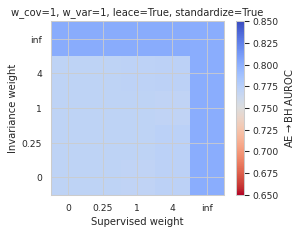

In [54]:
w_var = 1
subdf = df[df["w_var"] == w_var]
axis = [0, 0.25, 1, 4, np.inf]
heatmap = np.zeros((len(axis), len(axis)))
for i, w_inv in enumerate(axis):
    for j, w_sup in enumerate(axis):
        if w_inv == np.inf and w_sup == np.inf:
            element_df = subdf[(subdf["w_inv"] > 0) & (subdf["w_sup"] > 0) & (subdf["w_cov"] == 0)]
        elif w_inv == np.inf:
            element_df = subdf[(subdf["w_inv"] > 0) & (subdf["w_sup"] == 0) & (subdf["w_cov"] == 0)]
        elif w_sup == np.inf:
            element_df = subdf[(subdf["w_inv"] == 0) & (subdf["w_sup"] > 0) & (subdf["w_cov"] == 0)]
        else:
            element_df = subdf[(subdf["w_inv"] == w_inv) & (subdf["w_sup"] == w_sup) & (subdf["w_cov"] == 1)]
        if len(element_df) != len(current_args["ds_names"]):
            print(f"{len(element_df)} != {len(current_args['ds_names'])}")
        heatmap[i, j] = element_df["auroc"].mean()

plt.figure(figsize=(4, 3), dpi=75)
plt.imshow(heatmap, cmap="coolwarm_r", origin="lower", vmin=0.65, vmax=0.85)
plt.xticks(range(len(axis)), axis)
plt.yticks(range(len(axis)), axis)
plt.xlabel("Supervised weight")
plt.ylabel("Invariance weight")
plt.title(f"w_cov=1, w_var={w_var}, leace={current_args['use_leace']}, standardize={current_args['standardize_templates']}")
plt.colorbar(label=f"{current_args['fr']}$\\to${current_args['to']} {current_args['metric'].upper()}")

# Scatter plot for ID and OOD performance

In [118]:
from collections import defaultdict
from scipy.stats import linregress

current_args = dict(
    ds_names=ds_names.copy(),
    models=models,
    filter_by="all",
    weak_only=False,
    metric="auroc",
    reporter="vincs",
    use_leace=True,
    templatization_method="random",
    standardize_templates=True,
    full_finetuning=False,
    ensemble="full",
    label_col="alice_label",
)
if "H" in fr or "E" in fr:
    current_args["ds_names"].remove("population")  # difficulty is label
if filter_by == "disagreements":
    current_args["ds_names"].remove("authors")  # authors is only False for disagreements

hparams_list = [
        (var, inv, cov, supervised)
        for var in [0, 1]
        for inv in [0, 0.25, 1, 4]
        for cov in [1]
        for supervised in  [0, 0.25, 1, 4]
    ] + [
        (0, 0, 0, 1),
        (0, 1, 0, 1),
        (0, 1, 0, 0),
        (1, 0, 0, 1),
        (1, 1, 0, 1),
        (1, 1, 0, 0),
    ]
# hparams_list = [
#     (1, 0, 1, 0),  # CRC, should have "on-the-line" property
#     (0, 0, 0, 1),  # mean-diff on contrast pair, ~shouldn't have "on-the-line" property
#     (1, 0, 1, 1),  # convex combination of CRC and mean-diff
# ]
ds_names_without_pop = ds_names.copy()
ds_names_without_pop.remove("population")

id_aurocs = defaultdict(list)
ood_aurocs = defaultdict(list)
regressions = dict()
for hparams in hparams_list:
        
    for (fr, to) in [("AE", "AE"), ("AE", "BH")]:
        _, _, result_dfs, _, _, _ = get_result_dfs(fr=fr, to=to, vincs_hparams=hparams, **current_args)
        for model in models:
            for ds_name in ds_names_without_pop:
                aucs = result_dfs[(model, ds_name)]["auroc"].values
                if to == "AE" and fr == "AE":
                    id_aurocs[hparams].extend(aucs)
                elif to == "BH" and fr == "AE":
                    ood_aurocs[hparams].extend(aucs)
                else:
                    raise ValueError("Unexpected experiment")
    
    lin = linregress(id_aurocs[hparams], ood_aurocs[hparams])
    regressions[hparams] = lin

In [119]:
print(f"use_leace={current_args['use_leace']}, standardize_templates={current_args['standardize_templates']}")
print(f"w_var\tw_inv\tw_cov\tw_sup\tslope\tr\tid_auc\tood_auc")
sorted_hparams = sorted(hparams_list, key=lambda h: -regressions[h].slope)
for hparams in sorted_hparams:
    mean_id_auc = np.mean(id_aurocs[hparams])
    mean_ood_auc = np.mean(ood_aurocs[hparams])
    print("\t".join(map(str, hparams)), f"\t{regressions[hparams].slope:.3f}\t{regressions[hparams].rvalue:.3f}\t{mean_id_auc:.3f}\t{mean_ood_auc:.3f}")

use_leace=True, standardize_templates=True
w_var	w_inv	w_cov	w_sup	slope	r	id_auc	ood_auc
0	1	0	1 	0.916	0.867	0.660	0.626
0	0	0	1 	0.916	0.867	0.660	0.626
1	1	0	1 	0.906	0.861	0.699	0.651
0	1	0	0 	0.906	0.883	0.653	0.612
1	0	0	1 	0.903	0.860	0.699	0.652
1	1	0	0 	0.899	0.860	0.698	0.651
0	0	1	0 	0.859	0.831	0.676	0.627
0	0	1	4 	0.857	0.826	0.674	0.628
0	4	1	0 	0.852	0.832	0.674	0.626
0	0.25	1	0 	0.852	0.823	0.668	0.620
0	4	1	0.25 	0.851	0.829	0.675	0.627
0	0.25	1	1 	0.850	0.834	0.678	0.629
0	0	1	1 	0.848	0.827	0.680	0.629
0	0.25	1	4 	0.847	0.817	0.670	0.626
0	1	1	0 	0.846	0.827	0.676	0.626
0	1	1	0.25 	0.845	0.821	0.674	0.626
0	0	1	0.25 	0.844	0.817	0.670	0.620
0	0.25	1	0.25 	0.844	0.826	0.678	0.628
0	4	1	4 	0.844	0.814	0.671	0.625
0	4	1	1 	0.843	0.816	0.674	0.623
0	1	1	1 	0.836	0.826	0.678	0.629
0	1	1	4 	0.831	0.806	0.668	0.622
1	1	1	4 	0.805	0.804	0.671	0.617
1	0	1	4 	0.802	0.800	0.672	0.618
1	1	1	0 	0.802	0.802	0.667	0.617
1	1	1	0.25 	0.800	0.799	0.669	0.617
1	0	1	0.25 	0.799	0.798	0

In [121]:
linregress([hparams[2] for hparams in sorted_hparams], [regressions[hparams].slope for hparams in sorted_hparams])

LinregressResult(slope=-0.08610545188736761, intercept=0.9074986978175135, rvalue=-0.7923274958861716, pvalue=3.0878751373258195e-09, stderr=0.01105026914510291, intercept_stderr=0.010140422421564039)

/tmp/ipykernel_1772986/2673388255.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(id_aurocs[hparams][idx], ood_aurocs[hparams][idx], label=name if j == 0 else None, alpha=0.5, s=5, zorder=np.random.randint(0, 6), c=colors[i])


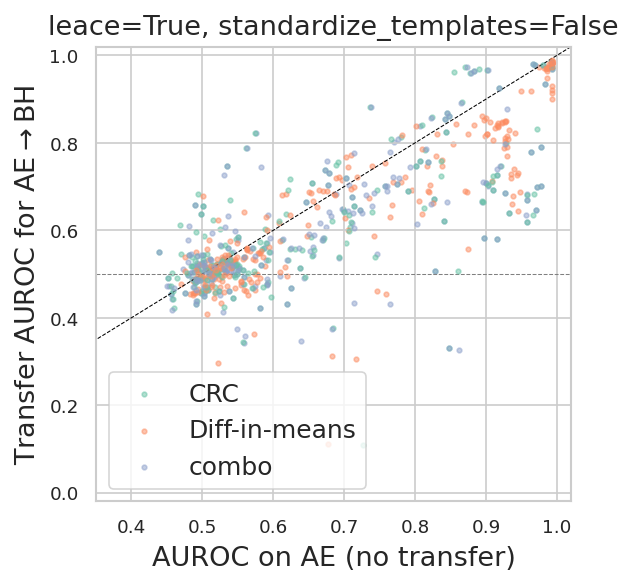

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
colors = sns.color_palette("Set2")

plt.figure(figsize=(4, 4), dpi=150)
n_show = 250
for i, (hparams, name) in enumerate(zip(id_aurocs, ["CRC", "Diff-in-means", "combo"])):
    sample = np.random.choice(len(id_aurocs[hparams]), n_show, replace=False)
    for j, idx in enumerate(sample):
        plt.scatter(id_aurocs[hparams][idx], ood_aurocs[hparams][idx], label=name if j == 0 else None, alpha=0.5, s=5, zorder=np.random.randint(0, 6), c=colors[i])
plt.plot([0, 2], [0, 2], color="black", linestyle="--", linewidth=0.5)
plt.axhline(0.5, color="grey", linestyle="--", linewidth=0.5)
plt.xlim(0.35, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel("AUROC on AE (no transfer)", fontsize=13)
plt.ylabel("Transfer AUROC for AE$\\to$BH", fontsize=13)
os.makedirs("../../figures", exist_ok=True)
plt.legend(fontsize=12, loc="lower left")
title = f"leace={current_args['use_leace']}, standardize_templates={current_args['standardize_templates']}"
plt.title(title, fontsize=13)
plt.tight_layout()
plt.show()

In [64]:
ood_aurocs[hparams]

[]